<a href="https://colab.research.google.com/github/unna97/fastai/blob/master/Planet(lesson_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.vision import *

Importing data from kaggle:
https://mmiakashs.github.io/blog/2018-09-20-kaggle-api-google-colab/

In [2]:
!pip3 install kaggle


In [5]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"unnati97","key":"9dd3d7638ec9bea0071200939d185ccc"}'}

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/


In [7]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [8]:
ls ~/.kaggle


kaggle.json


In [9]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 96% 577M/600M [00:05<00:00, 106MB/s] 
100% 600M/600M [00:05<00:00, 120MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 59.5MB/s]


In [10]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

In [12]:
path

PosixPath('/root/.fastai/data/planet')

In [14]:
!ls /root/.fastai/data/planet

__MACOSX  train-jpg  train-jpg.tar.7z  train_v2.csv  train_v2.csv.zip


In [13]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### Data Block API:https://blog.usejournal.com/finding-data-block-nirvana-a-journey-through-the-fastai-data-block-api-c38210537fe4

In [0]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

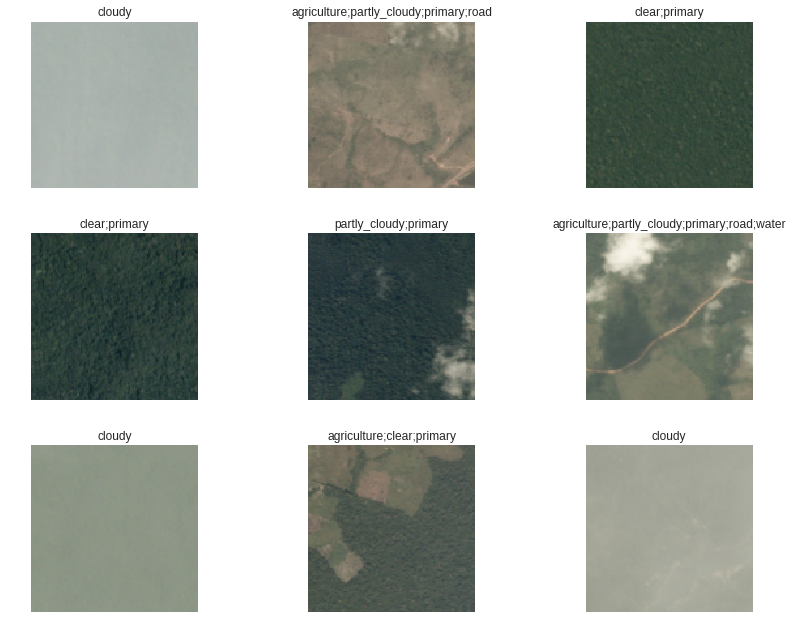

In [18]:
data.show_batch(rows=3, figsize=(12,9))


## Model

In [0]:
arch = models.resnet50


In [20]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 103633614.57it/s]


In [21]:
learn.lr_find()


epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


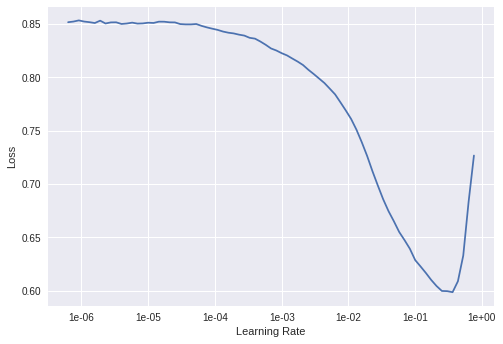

In [22]:
learn.recorder.plot()


In [0]:
lr = 0.01


In [24]:
learn.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.124880,0.108216,0.942397,0.905214
2,0.111367,0.098807,0.949998,0.914144
3,0.102144,0.091017,0.954816,0.922392
4,0.096118,0.087789,0.956960,0.924789
5,0.091971,0.086967,0.958079,0.925227


In [0]:
learn.save('stage-1-rn50')


In [0]:
learn.unfreeze()


epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


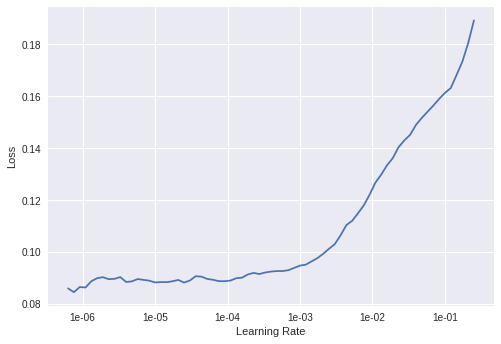

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.094381,0.090281,0.956502,0.921967
2,0.095280,0.091101,0.955129,0.922211
3,0.091076,0.086213,0.956029,0.926629
4,0.086732,0.083141,0.957948,0.928476
5,0.079979,0.082751,0.958348,0.928678


In [0]:
learn.save('stage-2-rn50')

In [30]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


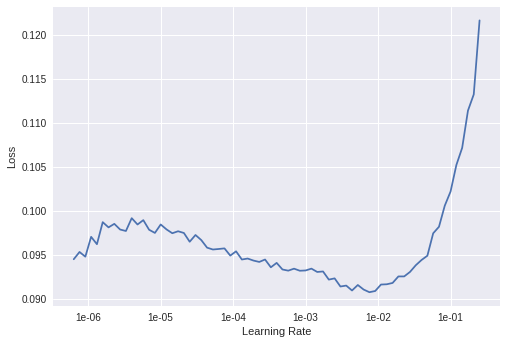

In [32]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [34]:
learn.fit_one_cycle(5, slice(lr))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.084284,0.085467,0.955972,0.925450
2,0.085559,0.082781,0.957090,0.929766
3,0.083711,0.082019,0.958740,0.929699
4,0.084057,0.081036,0.958624,0.930229
5,0.081244,0.080934,0.959728,0.931795


In [0]:
learn.save('stage-1-256-rn50')


In [0]:
learn.unfreeze()


In [37]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))


epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.083548,0.085528,0.956778,0.927079
2,0.086504,0.083487,0.956182,0.928520
3,0.082162,0.082376,0.957715,0.928972
4,0.079765,0.081131,0.959299,0.931030
5,0.076291,0.081006,0.960476,0.931291


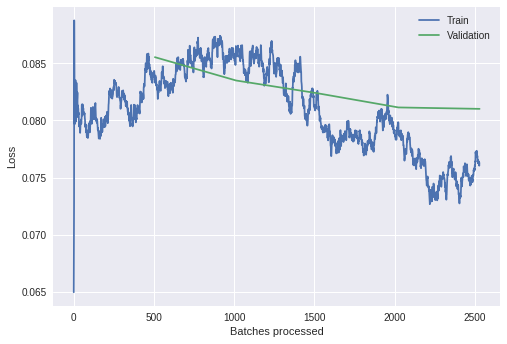

In [38]:
learn.recorder.plot_losses()


In [0]:
learn.save('stage-2-256-rn50')


In [0]:
learn.export()


In [43]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

 99% 598M/603M [00:08<00:00, 60.1MB/s]
100% 603M/603M [00:08<00:00, 73.5MB/s]
 96% 291M/304M [00:05<00:00, 30.6MB/s]
100% 304M/304M [00:05<00:00, 62.0MB/s]


In [45]:
test = ImageItemList.from_folder(path/'test-jpg').add(ImageItemList.from_folder(path/'test-jpg-additional'))
len(test)

AttributeError: ignored

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
labelled_preds[:5]

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])


In [0]:
df.to_csv(path/'submission.csv', index=False)


In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"
